# Part 1: Data ingestion


```
This demo works with the online feature store, which is currently not part of the Open Source default deployment.
```
This demo showcases financial fraud prevention using the MLRun feature store to define complex features that help identify 
fraud. Fraud prevention specifically is a challenge because it requires processing raw transaction and events in real-time, and 
being able to quickly respond and block transactions before they occur.

To address this, you create a development pipeline and a production pipeline. Both pipelines share the same feature 
engineering and model code, but serve data very differently. Furthermore, you automate the data and model monitoring 
process, identify drift and trigger retraining in a CI/CD pipeline. This process is described in the diagram below:

![Feature store demo diagram - fraud prevention](images/feature_store_demo_diagram.png)

By the end of this tutorial you’ll learn how to:

- Create an ingestion pipeline for each data source.
- Define preprocessing, aggregation and validation of the pipeline.
- Run the pipeline locally within the notebook.
- Launch a real-time function to ingest live data.
- Schedule a cron to run the task when needed.

The raw data is described as follows:

| TRANSACTIONS                                                                    || &#x2551; |USER EVENTS                                                                           || 
|-----------------|----------------------------------------------------------------|----------|-----------------|----------------------------------------------------------------|
| **age**         | age group value 0-6. Some values are marked as U for unknown   | &#x2551; | **source**      | The party/entity related to the event                          |
| **gender**      | A character to define the gender                               | &#x2551; | **event**       | event, such as login or password change                        |
| **zipcodeOri**  | ZIP code of the person originating the transaction             | &#x2551; | **timestamp**   | The date and time of the event                                 |
| **zipMerchant** | ZIP code of the merchant receiving the transaction             | &#x2551; |                 |                                                                |
| **category**    | category of the transaction (e.g., transportation, food, etc.) | &#x2551; |                 |                                                                |
| **amount**      | the total amount of the transaction                            | &#x2551; |                 |                                                                |
| **fraud**       | whether the transaction is fraudulent                          | &#x2551; |                 |                                                                |
| **timestamp**   | the date and time in which the transaction took place          | &#x2551; |                 |                                                                |
| **source**      | the ID of the party/entity performing the transaction          | &#x2551; |                 |                                                                |
| **target**      | the ID of the party/entity receiving the transaction           | &#x2551; |                 |                                                                |
| **device**      | the device ID used to perform the transaction                  | &#x2551; |                 |                                                                |

This notebook introduces how to **Ingest** different data sources to the **Feature Store**.

The following FeatureSets are created:
- **Transactions**: Monetary transactions between a source and a target.
- **Events**: Account events such as account login or a password change.
- **Label**: Fraud label for the data.

In [1]:
project_name = 'fraud-demo'

In [2]:
import mlrun

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True) 

> 2023-08-15 09:55:34,963 [info] Created and saved project: {'name': 'fraud-demo-jovyan', 'from_template': None, 'overwrite': False, 'context': './', 'save': True}
> 2023-08-15 09:55:34,965 [info] Project created successfully: {'project_name': 'fraud-demo', 'stored_in_db': True}


## Step 1 - Fetch, process and ingest the datasets

## 1.1 - Transactions

### Transactions

In [3]:
# Helper functions to adjust the timestamps of our data
# while keeping the order of the selected events and
# the relative distance from one event to the other

def date_adjustment(sample, data_max, new_max, old_data_period, new_data_period):
    '''
        Adjust a specific sample's date according to the original and new time periods
    '''
    sample_dates_scale = ((data_max - sample) / old_data_period)
    sample_delta = new_data_period * sample_dates_scale
    new_sample_ts = new_max - sample_delta
    return new_sample_ts

def adjust_data_timespan(dataframe, timestamp_col='timestamp', new_period='2d', new_max_date_str='now'):
    '''
        Adjust the dataframe timestamps to the new time period
    '''
    # Calculate old time period
    data_min = dataframe.timestamp.min()
    data_max = dataframe.timestamp.max()
    old_data_period = data_max-data_min
    
    # Set new time period
    new_time_period = pd.Timedelta(new_period)
    new_max = pd.Timestamp(new_max_date_str)
    new_min = new_max-new_time_period
    new_data_period = new_max-new_min
    
    # Apply the timestamp change
    df = dataframe.copy()
    df[timestamp_col] = df[timestamp_col].apply(lambda x: date_adjustment(x, data_max, new_max, old_data_period, new_data_period))
    return df

In [4]:
import pandas as pd

# Fetch the transactions dataset from the server
transactions_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# use only first 10k
transactions_data = transactions_data.sort_values(by='source', axis=0)[:10000]

# Adjust the samples timestamp for the past 2 days
transactions_data = adjust_data_timespan(transactions_data, new_period='2d')

# Sorting after adjusting timestamps
transactions_data = transactions_data.sort_values(by='timestamp', axis=0)

# Preview
transactions_data.head(3)

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device
274633,91,5,F,28007,28007,es_transportation,26.92,0,2023-08-13 09:56:09.149375000,C1022153336,M1823072687,33832bb8607545df97632a7ab02d69c4
286902,94,2,M,28007,28007,es_transportation,48.22,0,2023-08-13 09:56:27.443000913,C1006176917,M348934600,fadd829c49e74ffa86c8da3be75ada53
416998,131,3,M,28007,28007,es_transportation,17.56,0,2023-08-13 09:56:32.550170939,C1010936270,M348934600,58d0422a50bc40c89d2b4977b2f1beea


### Transactions - create a feature set and preprocessing pipeline
Create the feature set (data pipeline) definition for the **credit transaction processing** that describes the 
offline/online data transformations and aggregations.<br>
The feature store automatically adds an offline `parquet` target and an online `NoSQL` target by using `set_targets()`.

The data pipeline consists of:

* **Extracting** the data components (hour, day of week)
* **Mapping** the age values
* **One hot encoding** for the transaction category and the gender
* **Aggregating** the amount (avg, sum, count, max over 2/12/24 hour time windows)
* **Aggregating** the transactions per category (over 14 days time windows)
* **Writing** the results to **offline** (Parquet) and **online** (NoSQL) targets 

In [5]:
# Import MLRun's Feature Store
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import OneHotEncoder, MapValues, DateExtractor

In [6]:
# Define the transactions FeatureSet
transaction_set = fstore.FeatureSet("transactions", 
                                 entities=[fstore.Entity("source")], 
                                 timestamp_key='timestamp', 
                                 description="transactions feature set")

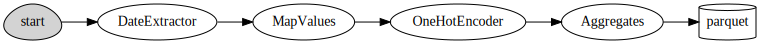

In [7]:
# Define and add value mapping
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]

# One Hot Encode the newly defined mappings
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(transactions_data.gender.unique())}

# Define the graph steps
transaction_set.graph\
    .to(DateExtractor(parts = ['hour', 'day_of_week'], timestamp_col = 'timestamp'))\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping))


# Add aggregations for 2, 12, and 24 hour time windows
transaction_set.add_aggregation(name='amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=['2h', '12h', '24h'],
                                period='1h')


# Add the category aggregations over a 14 day window
for category in main_categories:
    transaction_set.add_aggregation(name=category,column=f'category_{category}',
                                    operations=['sum'], windows=['14d'], period='1d')

# Add default (offline-parquet & online-nosql) targets
transaction_set.set_targets()

# Plot the pipeline so you can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)

### Transactions - ingestion

In [8]:
# Ingest your transactions dataset through your defined pipeline
transactions_df = fstore.ingest(transaction_set, transactions_data, 
                 infer_options=fstore.InferOptions.default())

transactions_df.head(3)

,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_count_2h,amount_count_12h,amount_count_24h,amount_max_2h,amount_max_12h,amount_max_24h,amount_avg_2h,...,category_es_contents,category_es_travel,category_es_leisure,amount,fraud,timestamp,target,device,timestamp_hour,timestamp_day_of_week
source,,,,,,,,,,,,,,,,,,,,,
C1022153336,26.92,26.92,26.92,1.0,1.0,1.0,26.92,26.92,26.92,26.92,...,0,0,0,26.92,0,2023-08-13 09:56:09.149375000,M1823072687,33832bb8607545df97632a7ab02d69c4,9,6
C1006176917,48.22,48.22,48.22,1.0,1.0,1.0,48.22,48.22,48.22,48.22,...,0,0,0,48.22,0,2023-08-13 09:56:27.443000913,M348934600,fadd829c49e74ffa86c8da3be75ada53,9,6
C1010936270,17.56,17.56,17.56,1.0,1.0,1.0,17.56,17.56,17.56,17.56,...,0,0,0,17.56,0,2023-08-13 09:56:32.550170939,M348934600,58d0422a50bc40c89d2b4977b2f1beea,9,6


After performing the ingestion process, you can see all of the different features that were created with the help of the UI, asshown in the image below.

![Features Catalog - fraud prevention](images/features-catalog-transaction.png)

## 1.2 - User events

### User events - fetching

In [9]:
# Fetch the user_events dataset from the server
user_events_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/events.csv', 
                               index_col=0, quotechar="\'", parse_dates=['timestamp'])

# Adjust to the last 2 days to see the latest aggregations in the online feature vectors
user_events_data = adjust_data_timespan(user_events_data, new_period='2d')

# Preview
user_events_data.head(3)

,source,event,timestamp
0,C1974668487,details_change,2023-08-14 19:04:28.157431086
1,C1973547259,login,2023-08-14 22:06:02.414571508
2,C515668508,login,2023-08-14 18:39:08.695748302


### User events - create a feature set and preprocessing pipeline

Now define the events feature set.
This is a pretty straightforward pipeline in which you only "one hot encode" the event categories and save the data to the default targets.

In [10]:
user_events_set = fstore.FeatureSet("events",
                           entities=[fstore.Entity("source")],
                           timestamp_key='timestamp', 
                           description="user events feature set")

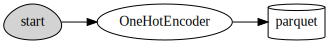

In [11]:
# Define and add value mapping
events_mapping = {'event': list(user_events_data.event.unique())}

# One Hot Encode
user_events_set.graph.to(OneHotEncoder(mapping=events_mapping))

# Add default (offline-parquet & online-nosql) targets
user_events_set.set_targets()

# Plot the pipeline so you can see the different steps
user_events_set.plot(rankdir="LR", with_targets=True)

### User Events - Ingestion

In [12]:
# Ingestion of your newly created events feature set
events_df = fstore.ingest(user_events_set, user_events_data)
events_df.head(3)

,event_details_change,event_login,event_password_change,timestamp
source,,,,
C1974668487,1,0,0,2023-08-14 19:04:28.157431086
C1973547259,0,1,0,2023-08-14 22:06:02.414571508
C515668508,0,1,0,2023-08-14 18:39:08.695748302


## Step 2 - Create a labels data set for model training

### Label set - create a feature set
This feature set contains the label for the fraud demo. It is ingested directly to the default targets without any changes.

In [13]:
def create_labels(df):
    labels = df[['fraud','timestamp']].copy()
    labels = labels.rename(columns={"fraud": "label"})
    labels['timestamp'] = labels['timestamp'].astype("datetime64[ms]")
    labels['label'] = labels['label'].astype(int)
    return labels

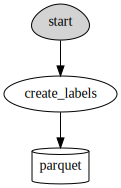

In [16]:
from mlrun.datastore import ParquetTarget
import os

# Define the "labels" feature set
labels_set = fstore.FeatureSet("labels", 
                           entities=[fstore.Entity("source")], 
                           timestamp_key='timestamp',
                           description="training labels",
                           engine="pandas")

labels_set.graph.to(name="create_labels", handler=create_labels)


# specify only Parquet (offline) target since its not used for real-time
labels_set.set_targets()
labels_set.plot(with_targets=True)

### Label set - ingestion

In [17]:
# Ingest the labels feature set
labels_df = fstore.ingest(labels_set, transactions_data)
labels_df.head(3)

,label,timestamp
source,,
C1022153336,0,2023-08-13 09:56:09.149
C1006176917,0,2023-08-13 09:56:27.443
C1010936270,0,2023-08-13 09:56:32.550


## Step 3 - Deploy a real-time pipeline

When dealing with real-time aggregation, it's important to be able to update these aggregations in real-time.
For this purpose, you create live serving functions that update the online feature store of the `transactions` 
FeatureSet and `Events` FeatureSet.

Using MLRun's `serving` runtime, create a nuclio function loaded with your feature set's computational graph definition
and an `HttpSource` to define the HTTP trigger.

Notice that the implementation below does not require any rewrite of the pipeline logic.

## 3.1 - Transactions

### Transactions - deploy the feature set live endpoint

In [21]:
import os

os.environ['REDIS_IP'] = '192.168.218.163'
os.environ['REDIS_PORT'] = '6379'
os.environ['KAFKA_IP'] = '192.168.218.163'
os.environ['KAFKA_PORT'] = '9092'

In [22]:
from environment import get_stream_uri

# Create iguazio v3io stream and transactions push API endpoint
transaction_stream = get_stream_uri(project.name,"transactions")
transaction_pusher = mlrun.datastore.get_stream_pusher(transaction_stream)

In [24]:
from environment import get_source_by_environment
# Define the source stream trigger (use v3io streams)
# define the `key` and `time` fields (extracted from the Json message).
source =  get_source_by_environment(transaction_stream)

In [25]:
# Deploy the transactions feature set's ingestion service over a real-time (Nuclio) serverless function
# you can use the run_config parameter to pass function/service specific configuration
transaction_set_endpoint, function = fstore.deploy_ingestion_service_v2(featureset=transaction_set, source=source)

> 2023-08-15 12:01:50,833 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-08-15 12:01:50,836 [info] Starting remote function deploy
2023-08-15 12:01:51  (info) Deploying function
2023-08-15 12:01:51  (info) Building
2023-08-15 12:01:51  (info) Staging files and preparing base images
2023-08-15 12:01:51  (info) Building processor image
2023-08-15 12:03:13  (info) Build complete
2023-08-15 12:03:30  (info) Function deploy complete
> 2023-08-15 12:03:32,684 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-jovyan-transactions-ingest.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['192.168.224.227:30962']}


### Transactions - test the feature set HTTP endpoint

By defining your `transactions` feature set you can now use MLRun and Storey to deploy it as a live endpoint, ready to ingest new data!

Using MLRun's `serving` runtime, create a nuclio function loaded with your feature set's computational graph definition 
and an `HttpSource` to define the HTTP trigger.

In [26]:
import requests
import json

# Select a sample from the dataset and serialize it to JSON
transaction_sample = json.loads(transactions_data.sample(1).to_json(orient='records'))[0]
transaction_sample['timestamp'] = str(pd.Timestamp.now())
transaction_sample

{'step': 39,
 'age': '4',
 'gender': 'M',
 'zipcodeOri': 28007,
 'zipMerchant': 28007,
 'category': 'es_transportation',
 'amount': 65.94,
 'fraud': 0,
 'timestamp': '2023-08-15 12:03:37.371640',
 'source': 'C1038722314',
 'target': 'M348934600',
 'device': 'fab7ff8d3c4c43678569af473301d2e3'}

In [27]:
# Post the sample to the ingestion endpoint
requests.post(transaction_set_endpoint, json=transaction_sample).text

'{"id": "6076d74f-cdf0-4c0e-8b2b-478ecf6fc034"}'

In [28]:
#push the event to the stream
transaction_pusher.push(transaction_sample)

## 3.2 - User events

### User events - deploy the feature set live endpoint
Deploy the events feature set's ingestion service using the feature set and all the previously defined resources.

In [29]:
# Create iguazio v3io stream and transactions push API endpoint
events_stream = get_stream_uri(project.name,"events")
events_pusher = mlrun.datastore.get_stream_pusher(events_stream)

In [30]:
# Define the source stream trigger (use v3io streams)
# define the `key` and `time` fields (extracted from the Json message).
source =  get_source_by_environment(events_stream)

# Deploy the transactions feature set's ingestion service over a real-time (Nuclio) serverless function
# you can use the run_config parameter to pass function/service specific configuration
events_set_endpoint, function = fstore.deploy_ingestion_service_v2(featureset=user_events_set, source=source)

> 2023-08-15 12:05:23,555 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-08-15 12:05:23,557 [info] Starting remote function deploy
2023-08-15 12:05:24  (info) Deploying function
2023-08-15 12:05:24  (info) Building
2023-08-15 12:05:24  (info) Staging files and preparing base images
2023-08-15 12:05:24  (info) Building processor image
2023-08-15 12:06:20  (info) Build complete
2023-08-15 12:06:36  (info) Function deploy complete
> 2023-08-15 12:06:45,172 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-jovyan-events-ingest.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['192.168.224.227:30717']}


### User Events - Test the feature set HTTP endpoint

In [31]:
# Select a sample from the events dataset and serialize it to JSON
user_events_sample = json.loads(user_events_data.sample(1).to_json(orient='records'))[0]
user_events_sample['timestamp'] = str(pd.Timestamp.now())
user_events_sample

{'source': 'C1255643141',
 'event': 'password_change',
 'timestamp': '2023-08-15 12:06:45.265900'}

In [32]:
# Post the sample to the ingestion endpoint
requests.post(events_set_endpoint, json=user_events_sample).text

'{"id": "9b908ae6-d45a-4e10-9ebe-768360ceb5d0"}'

In [33]:
#push the event to the stream
events_pusher.push(user_events_sample)

## Done!

You've completed Part 1 of the data-ingestion with the feature store.
Proceed to [Part 2](02-create-training-model.html) to learn how to train an ML model using the feature store data.